In [2]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

In [3]:
import numpy as np
import torch
import json
from equistore import Labels, TensorBlock, TensorMap
from torch_builder import TensorBuilder
import ase.io
from itertools import product
from torch_cg import ClebschGordanReal
from torch_hamiltonians import fix_pyscf_l1, dense_to_blocks, blocks_to_dense, couple_blocks, decouple_blocks, hamiltonian_features
import matplotlib.pyplot as plt
from rascal.representations import SphericalExpansion
import copy
from ase.units import Hartree

In [4]:
import sys
# sys.path.insert(0,'/Users//new-hamiltonian/equistore-examples')
from utils.librascal import  RascalSphericalExpansion, RascalPairExpansion
from utils.acdc_mini import acdc_standardize_keys, cg_increment, cg_combine

In [5]:
frames = ase.io.read("../data/hamiltonian/water-hamiltonian/water_coords_1000.xyz",":500")
for f in frames:
    f.cell = [100,100,100]
    f.positions += 50

In [6]:
#jorbs = json.load(open('data/water-hamiltonian/water_orbs.json', "r"))
jorbs = json.loads(json.load(open('../data/hamiltonian/water-hamiltonian/water_orbs.json', "r")))
orbs = {}
zdic = {"O" : 8, "H":1}
for k in jorbs:
    orbs[zdic[k]] = jorbs[k]

In [7]:
hams = np.load("../data/hamiltonian/water-hamiltonian/water_saph_orthogonal.npy", allow_pickle=True)[:len(frames)]
# NO NEED TO CORRECT L1 ORDER FOR SAPH ORTHOGONALIZED MATRICES...
#for i, f in enumerate(frames):
#    hams[i] = fix_pyscf_l1(hams[i], f, orbs)

In [8]:
cg = ClebschGordanReal(8)

In [9]:
#loss functions
def mse_full(fock, pred_blocks, frame, orbs):
    predicted = blocks_to_dense(decouple_blocks(pred_blocks), frame, orbs)
    mse_loss = torch.empty(len(frame))
    for i in range(len(frame)):
        mse_loss[i] = (torch.linalg.norm(fock[i]-predicted[i]))**2/len(fock[i])
        #print("from mse", i, fock[i], mse_loss[i])
    return torch.mean(mse_loss)*(Hartree)**2

def mse_eigvals(fock, pred_blocks, frame, orbs):
    predicted = blocks_to_dense(decouple_blocks(pred_blocks), frame, orbs)
    evanorm = torch.empty(len(frame))
    for i in range(len(frame)):
        evanorm[i] = torch.mean((torch.linalg.eigvalsh(fock[i]) - torch.linalg.eigvalsh(predicted[i]))**2)/len(fock[i])
    return torch.mean(evanorm)*(Hartree)**2

In [10]:
def normalize_feats(feat, all_blocks=True): 
    all_norm = 0
    for block_idx, block in feat: 
        block_norm = np.linalg.norm(block.values)
#         print(block_idx, block_norm)
        all_norm += block_norm**2
    normalized_blocks=[]
    for block_idx, block in feat: 
        newblock = TensorBlock(
                        values=block.values/np.sqrt(all_norm ),
                        samples=block.samples,
                        components=block.components,
                        properties= block.properties)
                    
        normalized_blocks.append(newblock) 
        
    norm_feat = TensorMap(feat.keys, normalized_blocks)
    return norm_feat

## Manipulate Hamiltonian into blocks

In [11]:
blocks = dense_to_blocks(hams, frames, orbs)
fock_bc = couple_blocks(blocks, cg)

## Feature computation

In [12]:
rascal_hypers = {
    "interaction_cutoff": 4,
    "cutoff_smooth_width": 0.5,
    "max_radial": 12,
    "max_angular": 8,
    "gaussian_sigma_type": "Constant",
    "compute_gradients":  False,
}

spex = RascalSphericalExpansion(rascal_hypers)
rhoi = spex.compute(frames)

In [13]:
pairs = RascalPairExpansion(rascal_hypers)
gij = pairs.compute(frames)

In [14]:
rho1i = acdc_standardize_keys(rhoi)
rho1i.keys_to_properties(['species_neighbor'])
gij =  acdc_standardize_keys(gij)

In [16]:
rho2i = cg_increment(rho1i, rho1i, lcut=2, other_keys_match=["species_center"], clebsch_gordan=cg)

In [ ]:
#rho3i = cg_increment(rho2i, rho1i, lcut=2, other_keys_match=["species_center"], clebsch_gordan=cg)

In [17]:
rho1ij = cg_increment(rho1i, gij, lcut=2, other_keys_match=["species_center"], clebsch_gordan=cg)

In [ ]:
#rho2ij = cg_increment(rho2i, gij, lcut=2, other_keys_match=["species_center"], clebsch_gordan=cg)

In [18]:
ham_feats = hamiltonian_features(rho2i, rho1ij)

In [19]:
norm_ham_feats = normalize_feats(ham_feats)

# Pytorch Model

In [20]:
class LinearModel(torch.nn.Module):
    def __init__(self, coupled_blocks, features, weights=None, intercepts=None):
        super().__init__()
        self.coupled_blocks = coupled_blocks
        self.features = features
        self.weights = {}
        if weights==None:
            for idx_fock, block_fock in self.coupled_blocks:
                block_type, ai, ni, li, aj, nj, lj, L = idx_fock
                parity= (-1)**(li+lj+L)
                size = self.features.block(block_type=block_type, spherical_harmonics_l=L,inversion_sigma=parity, 
                                       species_center=ai, species_neighbor=aj).values.shape[2]
                self.weights[idx_fock] = torch.nn.Parameter(torch.zeros(size, dtype=torch.float64))
            
        else: 
            self.weights = weights
            
        if intercepts is not None:
            self.intercepts = intercepts 
            
        else:
            self.intercepts = None
         
    def forward(self, features):
        k = []
        pred_blocks = []
        for (idx, wts) in self.weights.items():
            #print(wts)
            block_type, ai, ni, li, aj, nj, lj, L = idx
            k.append(list(idx))
            parity= (-1)**(li+lj+L)
            X = features.block(block_type=block_type, spherical_harmonics_l=L,inversion_sigma=parity, 
                                   species_center=ai, species_neighbor=aj)
            X_new = torch.from_numpy(X.values.reshape(-1, X.values.shape[2]))
            #print(idx, wts.shape, X.values.shape, X_new.shape)
            if self.intercepts is not None:
                Y = X_new @ wts + self.intercepts[idx]
            else:
                Y = X_new @ wts
            
            newblock = TensorBlock(
                        values=Y.reshape((-1, 2 * L + 1, 1)),
                        samples=X.samples,
                        components=[Labels(
                            ["mu"], np.asarray(range(-L, L + 1), dtype=np.int32).reshape(-1, 1)
                        )],
                        properties= Labels(["values"], np.asarray([[0]], dtype=np.int32))
                    )
            pred_blocks.append(newblock) 
        
        keys = Labels(('block_type', 'a_i', 'n_i', 'l_i', 'a_j', 'n_j', 'l_j', 'L'), np.asarray(k, dtype=np.int32))
        pred_fock = TensorMap(keys, pred_blocks)
        return(pred_fock)
        ### add direct eigenvalue prediction here as well
    
    def parameters(self):
        for idx, wts in self.weights.items():
            yield wts        

# For single frame

In [71]:
i_frame = frames[0]
i_ham = hams[0] 

i_feats = ham_feats.slice(Labels(names=["structure"], values=np.asarray(range(1), dtype=np.int32).reshape(-1,1)) )
i_focks = fock_bc.slice(Labels(names=["structure"], values=np.asarray(range(1), dtype=np.int32).reshape(-1,1)) )

In [341]:
norm_i_feats = normalize_feats(i_feats)

In [342]:
np.linalg.norm(norm_i_feats.block(0).values)

0.40170182960459544

### Testing the model with weights from equistore

In [292]:
weights = np.load('model_weights.npy', allow_pickle=True)[()]
intercepts = np.load('model_intercepts.npy', allow_pickle=True)[()]

In [293]:
model = LinearModel(i_focks, norm_i_feats, weights=weights, intercepts=intercepts)
print(f"the model contains {len(list(model.parameters()))} parameters")

pred = model(norm_i_feats)

the model contains 8 parameters


In [294]:
loss = mse_full([torch.from_numpy(i_ham.astype(np.float64))], pred, [i_frame], orbs)
print(torch.sqrt(loss))

tensor(595.3569)


### Training with loss on full Hamiltonian

In [ ]:
model = LinearModel(i_focks, norm_i_feats)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15000, gamma=0.01)

all_losses = []
for epoch in range(3000):
    optimizer.zero_grad()
    pred = model(norm_i_feats)
    loss = mse_full([torch.from_numpy(i_ham.astype(np.float64))], pred, [i_frame], orbs)
    loss.backward()
    
    optimizer.step()
#     scheduler.step()
    
    all_losses.append(loss.item())

    if epoch % 500 == 0:
        print(epoch, loss.item())

Text(0,0.5,'$MSE_{full}$')

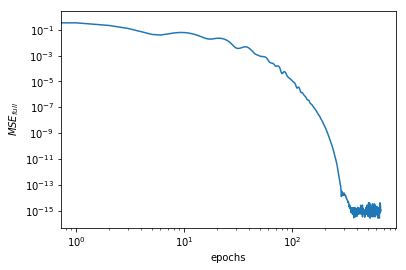

In [296]:
plt.loglog(all_losses)

plt.xlabel("epochs")
plt.ylabel("$MSE_{full}$")

In [297]:
pred = model(norm_i_feats)
mse_full([torch.from_numpy(i_ham.astype(np.float64))], pred, [i_frame], orbs)

tensor(4.7829e-16, grad_fn=<MeanBackward0>)

### Training with loss on eigenvalues

In [47]:
model = LinearModel(i_focks, i_feats)
optimizer = torch.optim.Adam(model.parameters(), lr=0.8)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10000, gamma=0.01)

eigval_losses = []
for epoch in range(30000):
    optimizer.zero_grad()
    pred = model(i_feats[0])
    eigval_loss = mse_eigvals([torch.from_numpy(i_ham.astype(np.float64))], pred, [i_frame], orbs)
    eigval_loss.backward()
    optimizer.step()
    
    eigval_losses.append(eigval_loss.item())

    if epoch % 1000 == 0:
        print(epoch, eigval_loss.item())
    
    scheduler.step()

0 0.07313249260187149
1000 0.00026996646192856133
2000 5.596232099946974e-08
3000 2.7129460719479796e-14
4000 2.6957009893616504e-15
5000 9.686255856238392e-16
6000 1.296768690488997e-15
7000 3.0241524142196087e-15
8000 4.065183858482403e-15
9000 4.32505907241418e-15
10000 4.389821093978875e-15
11000 6.49571885436549e-16
12000 1.186469648284318e-15
13000 1.9500161695210376e-15
14000 1.2387532863491818e-15
15000 1.461137551486062e-15
16000 1.8999177705809715e-15
17000 2.0405432392753145e-15
18000 2.1838470261488756e-15
19000 6.112263439253442e-15
20000 1.3493779068429615e-15
21000 1.7296043264809573e-15
22000 1.7296043264809573e-15
23000 1.7296043264809573e-15
24000 1.7296043264809573e-15
25000 5.531865770003837e-16
26000 5.531865770003837e-16
27000 3.3424373261281472e-15
28000 3.3424373261281472e-15
29000 2.224811445302225e-15


Text(0, 0.5, '$MSE_{\\epsilon}$')

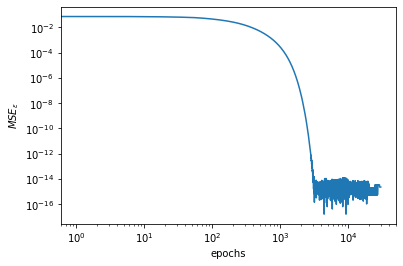

In [48]:
plt.loglog(eigval_losses)

plt.xlabel("epochs")
plt.ylabel("$MSE_{\epsilon}$")

In [49]:
pred_coupled = model(ham_feats)
rmse_full = torch.sqrt(mse_full([torch.from_numpy(i_ham.astype(np.float64))], pred, [i_frame], orbs))
print(rmse_full)

tensor(0.8015, grad_fn=<SqrtBackward0>)


# Train and test on multiple frames

### Split into train and test set

In [21]:
N=len(frames)
train_frames = frames[:int(N/5*4)]
train_hams = hams[:int(N/5*4)]
train_feats = norm_ham_feats.slice(Labels(names=["structure"], values=np.asarray(range(int(N/5*4)), dtype=np.int32).reshape(-1,1)) )
train_focks = fock_bc.slice(Labels(names=["structure"], values=np.asarray(range(int(N/5*4)), dtype=np.int32).reshape(-1,1)) )

In [22]:
test_frames = frames[int(N/5*4):N]
test_hams = hams[int(N/5*4):N]
test_feats = norm_ham_feats.slice(Labels(names=["structure"], values=np.asarray(range(int(N/5*4),N), dtype=np.int32).reshape(-1,1)) )
test_focks = fock_bc.slice(Labels(names=["structure"], values=np.asarray(range(int(N/5*4),N), dtype=np.int32).reshape(-1,1)) )

In [28]:
model = LinearModel(train_focks, train_feats)
optimizer = torch.optim.Adam(model.parameters(), lr=0.8)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5000, gamma=0.1)

all_losses = []
for epoch in range(30000):
    optimizer.zero_grad()
    pred = model(train_feats)
    loss = mse_full(torch.from_numpy(train_hams.astype(np.float64)), pred, train_frames, orbs)
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    all_losses.append(loss.item())
    
    if epoch % 500 == 0:
        print(epoch, loss.item()) 
#     if loss.item <1e-15: 
#         break 

0 349.7143859863281
500 0.009680550545454025
1000 0.003445796202868223
1500 0.0013143842807039618
2000 0.0005941925337538123
2500 0.00035052531166002154
3000 0.00024819449754431844
3500 0.00028709255275316536
4000 0.00015761492250021547
4500 0.00011576754332054406
5000 0.0001270314387511462
5500 8.723978680791333e-05
6000 8.411426097154617e-05
6500 8.038501982809976e-05
7000 7.601027755299583e-05
7500 7.097989146132022e-05
8000 6.533099076477811e-05
8500 5.9160789533052593e-05
9000 5.263784623821266e-05
9500 4.599741077981889e-05
10000 4.274144157534465e-05
10500 3.885705882566981e-05
11000 3.802467108471319e-05
11500 3.703000766108744e-05
12000 3.585891317925416e-05
12500 3.4504435461713e-05
13000 3.296756403869949e-05
13500 3.126281808363274e-05
14000 2.9415419703582302e-05
14500 2.746515383478254e-05
15000 2.5511222702334635e-05
15500 2.5251025363104418e-05
16000 2.4996150386868976e-05
16500 2.4698083507246338e-05
17000 2.435383248666767e-05
17500 2.396054333075881e-05
18000 2.35172

0.00448430461530545 eV rmse on TRAIN H prediction


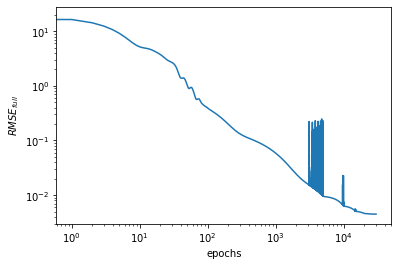

In [30]:
plt.loglog(np.sqrt(all_losses))

plt.xlabel("epochs")
plt.ylabel("$RMSE_{full}$")
print(np.sqrt(all_losses[-1]), "eV rmse on TRAIN H prediction")

In [32]:
pred_all = model(norm_ham_feats.slice(Labels(names=["structure"], values=np.asarray(range(N), dtype=np.int32).reshape(-1,1)) ))
all_loss = mse_full(torch.from_numpy(hams[:N].astype(np.float64)), pred_all, frames[:N], orbs)
print(torch.sqrt(all_loss), "eV rmse on ALL H prediction")
# test_loss_eigvals = mse_eigvals(torch.from_numpy(test_hams.astype(np.float64)), pred_test, test_frames, orbs)

tensor(0.0045, grad_fn=<SqrtBackward0>) eV rmse on ALL H prediction


In [33]:
###TEMPORARY FIX to reindex just the test frames 
pred_test = model(test_feats)
bvalues = []
for i, b in pred_test:
    newblock = TensorBlock(
                        values=b.values,
                        samples=pred.block(i).samples[:len(b.values)],
                        components=b.components,
                        properties= b.properties)
                    
    bvalues.append(newblock) 
        
reindexed_pred_test  = TensorMap(test_focks.keys, bvalues)

In [34]:
# reindexed_pred_test.block(0).samples

In [36]:
test_loss = mse_full(torch.from_numpy(test_hams.astype(np.float64)), reindexed_pred_test, test_frames, orbs)
test_loss_eigvals = mse_eigvals(torch.from_numpy(test_hams.astype(np.float64)), reindexed_pred_test, test_frames, orbs)
print(torch.sqrt(test_loss),  "eV rmse on TEST H prediction")
print(torch.sqrt(test_loss_eigvals),  "eV rmse on TEST eigen prediction")

tensor(0.0047, grad_fn=<SqrtBackward0>) eV rmse on TEST H prediction
tensor(0.0012, grad_fn=<SqrtBackward0>) eV rmse on TEST eigen prediction


## Training on eigenvalue loss

In [24]:
model = LinearModel(train_focks, train_feats)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5000, gamma=0.1)

all_eigval_losses = []
all_losses = []
combined_loss = []
for epoch in range(30000):
    optimizer.zero_grad()
    pred = model(train_feats)
    eva_loss = mse_eigvals(torch.from_numpy(train_hams.astype(np.float64)), pred, train_frames, orbs)
    full_loss = mse_full(torch.from_numpy(train_hams.astype(np.float64)), pred, train_frames, orbs)
    loss_combined = 0.1*eva_loss + full_loss
    loss_combined.backward()
    optimizer.step()
    scheduler.step()
    
    all_eigval_losses.append(eva_loss.item())
    all_losses.append(full_loss.item())
    combined_loss.append(loss_combined.item())
    
    if epoch % 500 == 0:
        print(epoch, loss_combined.item(), eva_loss.item(), full_loss.item())

0 355.54296875 58.28573226928711 349.7143859863281
500 0.12366901338100433 0.011495102196931839 0.12251950055360794
1000 0.062106408178806305 0.005475901998579502 0.06155881658196449
1500 0.0390036515891552 0.0033128391951322556 0.038672368973493576
2000 0.026653792709112167 0.002200164832174778 0.026433777064085007
2500 0.01905611716210842 0.0015364699065685272 0.01890246942639351
3000 0.0140019990503788 0.001106412266381085 0.01389135792851448
3500 0.010461311787366867 0.0008121316786855459 0.010380098596215248
4000 0.00788682047277689 0.0006027652998454869 0.007826544344425201
4500 0.005986376665532589 0.00045007228618487716 0.005941369570791721
5000 0.004554461687803268 0.000338961515808478 0.004520565737038851
5500 0.003945237956941128 0.0002890681498683989 0.003916331101208925
6000 0.0032058036886155605 0.00023215336841531098 0.003182588377967477
6500 0.002501914743334055 0.0001794292329577729 0.002483971882611513
7000 0.001896281843073666 0.00013493417645804584 0.001882788375951

Text(0, 0.5, '$RMSE_{\\epsilon}$')

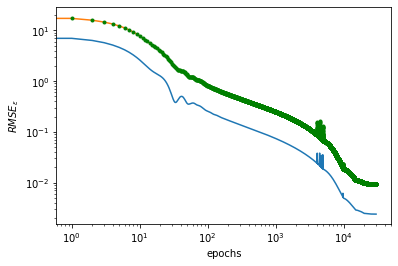

In [34]:
plt.loglog(np.sqrt(all_eigval_losses))
plt.loglog(np.sqrt(all_losses))
plt.loglog(np.sqrt(combined_loss), 'g.')

plt.xlabel("epochs")
plt.ylabel("$RMSE_{\epsilon}$")

In [35]:
pred_test = model(test_feats)
bvalues = []
for i, b in pred_test:
    newblock = TensorBlock(
                        values=b.values,
                        samples=pred.block(i).samples[:len(b.values)],
                        components=b.components,
                        properties= b.properties)
                    
    bvalues.append(newblock) 
        
reindexed_pred_test  = TensorMap(test_focks.keys, bvalues)

In [36]:
test_loss = mse_full(torch.from_numpy(test_hams.astype(np.float64)), reindexed_pred_test, test_frames, orbs)
test_loss_eigvals = mse_eigvals(torch.from_numpy(test_hams.astype(np.float64)), reindexed_pred_test, test_frames, orbs)
print(torch.sqrt(test_loss),  "eV rmse on TEST H prediction")
print(torch.sqrt(test_loss_eigvals),  "eV rmse on TEST eigen prediction")

tensor(0.0089, grad_fn=<SqrtBackward0>) eV rmse on TEST H prediction
tensor(0.0023, grad_fn=<SqrtBackward0>) eV rmse on TEST eigen prediction


## Train first on MSE_full and then retrain on MSE_eigenvalues

In [45]:
model = LinearModel(train_focks, train_feats)
optimizer = torch.optim.Adam(model.parameters(), lr=0.8)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5000, gamma=0.1)

all_losses = []
for epoch in range(3000):
    optimizer.zero_grad()
    pred = model(train_feats)
    loss = mse_full(torch.from_numpy(train_hams.astype(np.float64)), pred, train_frames, orbs)
    loss.backward()
    optimizer.step()
    #scheduler.step()
    
    all_losses.append(loss.item())
    
    if epoch % 100 == 0:
        print(epoch, loss.item()) 

0 349.7143859863281
100 0.15334588289260864
200 0.040071986615657806
300 0.017358414828777313
400 0.012214300222694874
500 0.009680550545454025
600 0.007818610407412052
700 0.006348025519400835
800 0.0051681832410395145
900 0.0042160614393651485
1000 0.003445796202868223
1100 0.0028221982065588236
1200 0.0023174972739070654
1300 0.0019094205927103758
1400 0.0015799348475411534
1500 0.0013143842807039618
1600 0.001100808149203658
1700 0.0009294012561440468
1800 0.000792086822912097
1900 0.0006821900606155396
2000 0.0005941925337538123
2100 0.000523551891092211
2200 0.0004665612068492919
2300 0.0004202288982924074
2400 0.000382173340767622
2500 0.00035052531166002154
2600 0.00032383709913119674
2700 0.00030100124422460794
2800 0.0002811782469507307
2900 0.00026373498258180916


In [48]:
all_eigval_losses = []
all_ham_losses = []
combined_loss = []

for epoch in range(3000):
    optimizer.zero_grad()
    re_pred = model(train_feats)
    loss1 = mse_full(torch.from_numpy(train_hams.astype(np.float64)), re_pred, train_frames, orbs)
    loss2 = mse_eigvals(torch.from_numpy(train_hams.astype(np.float64)), re_pred, train_frames, orbs)
    loss_combined = loss1 + loss2
    loss_combined.backward()
    optimizer.step()
    #scheduler.step()
    
    all_eigval_losses.append(loss2.item())
    all_ham_losses.append(loss1.item())
    combined_loss.append(loss_combined.item())
    
    if epoch % 500 == 0:
        print("Epoch:", epoch, "combined:", loss_combined.item(), "MSE_full:", loss1.item(), "MSE_eva:", loss2.item())

Epoch: 0 combined: 7.65964068705216e-05 MSE_full: 7.254196680150926e-05 MSE_eva: 4.0544377952755895e-06
Epoch: 500 combined: 0.0008116356329992414 MSE_full: 0.0007132518221624196 MSE_eva: 9.838381811277941e-05
Epoch: 1000 combined: 6.988879613345489e-05 MSE_full: 6.406062311725691e-05 MSE_eva: 5.828169832966523e-06
Epoch: 1500 combined: 0.0017141797579824924 MSE_full: 0.0014890845632180572 MSE_eva: 0.00022509516566060483
Epoch: 2000 combined: 0.00087914610048756 MSE_full: 0.0007573447073809803 MSE_eva: 0.0001218014003825374
Epoch: 2500 combined: 0.0001345453056273982 MSE_full: 0.00011772434663726017 MSE_eva: 1.6820955352159217e-05


In [49]:
pred_test = model(test_feats)
bvalues = []
for i, b in pred_test:
    newblock = TensorBlock(
                        values=b.values,
                        samples=pred.block(i).samples[:len(b.values)],
                        components=b.components,
                        properties= b.properties)
                    
    bvalues.append(newblock) 
        
reindexed_pred_test  = TensorMap(test_focks.keys, bvalues)

In [50]:
test_loss = mse_full(torch.from_numpy(test_hams.astype(np.float64)), reindexed_pred_test, test_frames, orbs)
test_loss_eigvals = mse_eigvals(torch.from_numpy(test_hams.astype(np.float64)), reindexed_pred_test, test_frames, orbs)
print(torch.sqrt(test_loss),  "eV rmse on TEST H prediction")
print(torch.sqrt(test_loss_eigvals),  "eV rmse on TEST eigen prediction")

tensor(0.0125, grad_fn=<SqrtBackward0>) eV rmse on TEST H prediction
tensor(0.0047, grad_fn=<SqrtBackward0>) eV rmse on TEST eigen prediction
